# [SF-DST] Car Price prediction
Цель проекта - собрать, проанализировать и обработать данные с сайта авто.ру. На основе этих данных создать модель, предсказывающую стоимость автомобиля.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
import json
import time
from pprint import pprint
import requests
from lightgbm import LGBMRegressor
import lightgbm as lgb
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
import catboost as ctb
from catboost import CatBoostRegressor, Pool, cv
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from bs4 import BeautifulSoup
import ast
import seaborn as sns
import os
import numpy as np
import pandas as pd
from pandas import Series
# import sweetviz as sv данная библиотека не работает на кагле, только на локальной машине
import re
import random
import matplotlib.pyplot as plt
%matplotlib inline


pd.set_option('display.max_columns', 50)

In [ ]:
# Функции
def mape(y_true, y_pred):
    '''Функция для определения метрики MAPE'''
    return np.mean(np.abs((y_pred-y_true)/y_true))*100


results = []


def model_results(name, model, X_train, X_test, y_train, y_test):
    ''' Функция принимает на вход название модели, саму модель, тестовые и 
    тренировочные значения. Обучает модель и считает метрику MAPE(учитывая логарифм от цены), после чего
    записывает название модели и получившуюся метрику в таблицу
    '''
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = mape(np.exp(y_test), np.exp(y_pred))
    results = pd.DataFrame(
        {
            'Model': str(model),
            'MAPE': score
        }, index=[name])

    return results




In [ ]:
random.seed(42)
RANDOM_SEED = 42

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# 1. Сбор данных

Для сбора данных применялся следующий алгоритм:
из тестового датасета взяли все бренды автомобилей, далее создали словарь, где ключами были бренды авто, а значениями были ссылки на продаваемые автомобили.
Далее для каждого бренда был создан датасет, в который добавили все интересующие нас параметры со страницы объявления. Потом объединили все датасеты брендов в один тренировочный датасет


In [ ]:
# from tqdm.notebook import tqdm
# % % capture
# tqdm().pandas()

# df_test = pd.read_csv('test.csv')

# brands = []
# brands = list(set(df_test.brand))

# url = 'https://auto.ru/moskva/cars/'
# cars_urls = {}
# for car_brand in brands:
#     brand_url = url + car_brand + '/used/?page='
#     cars_urls[car_brand] = []
#     print(car_brand)
#     for number in range(1, 100):
#         response = requests.get(brand_url+str(number),
#                                 headers={'User-Agent': 'Mozilla/5.0'})
#         page = BeautifulSoup(response.text, 'html.parser')
#         link_list = page.find_all(
#             'a', class_='Link ListingItemTitle-module__link')
#         if len(link_list) != 0:
#             for link in link_list:
#                 cars_urls[car_brand].append(link['href'])
#         else:
#             break
#     print(len(cars_urls[car_brand]))
# with open('data1.json', 'w') as fp:
#     json.dump(cars_urls, fp)

# brand = 'HONDA'
# global_list = []
# data[brand][0]

# with tqdm(total=len(data[brand])) as pbar:
#     for urls in data[brand]:
#         try:
#             url = urls
#             response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
#             if response.status_code != 200:
#                 raise BaseException(
#                     "response code" + str(response.status_code))
#             response.encoding = 'utf-8'
#             page = BeautifulSoup(response.text, 'html.parser')
#             param_dic = ast.literal_eval(
#                 page.find_all('script')[0].contents[0])
#             auto_list = []
#             auto_list.append(param_dic['bodyType'])
#             auto_list.append(param_dic['brand'])
#             auto_list.append(url)
#             auto_list.append(param_dic['color'])
#             auto_list.append(param_dic['vehicleEngine']['engineDisplacement'])
#             auto_list.append(param_dic['vehicleEngine']['enginePower'])
#             auto_list.append(param_dic['vehicleEngine']['fuelType'])
#             auto_list.append((str.split(page.find_all('li', class_='CardInfoRow CardInfoRow_kmAge')[0].find_all('span')[1].text)[0] +
#                               str.split(page.find_all('li', class_='CardInfoRow CardInfoRow_kmAge')[0].find_all('span')[1].text)[1]))
#             auto_list.append(param_dic['modelDate'])
#             auto_list.append(page.find_all(
#                 'a', class_="Link Link_color_gray CardBreadcrumbs__itemText")[3].text)
#             auto_list.append(param_dic['name'])
#             auto_list.append(param_dic['numberOfDoors'])
#             auto_list.append(param_dic['offers']['priceCurrency'])
#             auto_list.append(param_dic['productionDate'])
#             auto_list.append(param_dic['vehicleConfiguration'])
#             auto_list.append(param_dic['vehicleTransmission'])
#             auto_list.append(str.split(page.find_all(
#                 'li', class_='CardInfoRow CardInfoRow_ownersCount')[0].find_all('span')[1].text)[0])
#             try:
#                 auto_list.append(page.find_all('li', class_='CardInfoRow CardInfoRow_owningTime')[
#                                  0].find_all('span')[1].text)
#             except:
#                 auto_list.append(None)
#             try:
#                 auto_list.append(page.find_all('li', class_='CardInfoRow CardInfoRow_pts')[
#                                  0].find_all('span')[1].text)
#             except:
#                 auto_list.append(None)
#             auto_list.append(page.find_all('li', class_='CardInfoRow CardInfoRow_drive')[
#                              0].find_all('span')[1].text)
#             auto_list.append(page.find_all('li', class_='CardInfoRow CardInfoRow_wheel')[
#                              0].find_all('span')[1].text)
#             auto_list.append(page.find_all('li', class_='CardInfoRow CardInfoRow_state')[
#                              0].find_all('span')[1].text)
#             auto_list.append(page.find_all('li', class_='CardInfoRow CardInfoRow_customs')[
#                              0].find_all('span')[1].text)
#             try:
#                 auto_list.append(param_dic['offers']['price'])
#             except:
#                 auto_list.append(None)
#             global_list.append(auto_list)
#             pbar.update(1)
#         except:
#             print(url)
#             continue

# df_honda = pd.DataFrame(global_list,
#                         columns=['bodyType', 'brand', 'url', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_name', 'name', 'numberOfDoors', 'priceCurrency', 'productionDate', 'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'price'])

# 2. Подготовка датасета

In [ ]:
DIR_TEST = '../input/sf-dst-car-price-prediction/'
test = pd.read_csv(DIR_TEST + 'test.csv')
sample_submission = pd.read_csv(DIR_TEST + 'sample_submission.csv')

In [ ]:
DIR_TRAIN = '../input/car-price/'
train = pd.read_csv(DIR_TRAIN + 'train.csv')

In [ ]:
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:
# Преобразим столбец теста 'Владельцы' в формат трейна
test['Владельцы'] = test['Владельцы'].apply(lambda x: int(x.split()[0]))

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
# Удалим ненужные столбцы из трейна и теста
train_drop_columns = ['url', 'priceCurrency']
train.drop(train_drop_columns, axis=1, inplace=True)

test_drop_columns = ['car_url', 'complectation_dict', 'description', 'equipment_dict',
                     'image', 'model_info', 'parsing_unixtime', 'priceCurrency', 'sell_id', 'super_gen', 'vendor']
test.drop(test_drop_columns, axis=1, inplace=True)

In [ ]:
# Проверим дубликаты в трейне
train.duplicated().sum()

In [ ]:
train[train.duplicated()]

In [ ]:
# Удалим их
train.drop_duplicates(keep='last', inplace=True)

In [ ]:
# Поставим метки 'sample' для различия трейна и теста и объединим таблицы в одну
train['sample'] = 1
test['sample'] = 0
df = train.append(test, ignore_index=True, sort=False)

In [ ]:
# Найдем дубликаты после объединения
subset = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
          'fuelType', 'mileage', 'modelDate', 'model_name',
          'numberOfDoors', 'productionDate', 'vehicleConfiguration',
          'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
          'Состояние', 'Таможня']
duplicates = df.duplicated(subset=subset, keep=False)

In [ ]:
# Так мы нашли дубликаты между трейном и тестом, но также сюда попали дубликаты между тестом и тестом. Поэтому удалим только те дубликаты, которые в трейне:
df = df[~duplicates | (df['sample'] != 1)]

In [ ]:
# Теперь проверим суммарное кол-во дубликатов
df.duplicated(subset=subset, keep=False).sum()

In [ ]:
# И кол-во дубликатов в тесте
df[df['sample'] == 0].duplicated(subset=subset, keep=False).sum()

In [ ]:
df.reset_index(drop=True, inplace=True)

## 2.1 Преобразование  датасета


In [ ]:
# # Бегло ознакомимся с имеющимися данными
# # Для анализа всего датасета использовалась библиотека sweetviz, результаты выводились в ноутбуке 
# # и в виде html файла
# df_sv = sv.compare(df[df['sample']==1], df[df['sample']==0])
# df_sv.show_notebook()
# df_sv.show_html('Compare.html')

Так выглядит отчет 
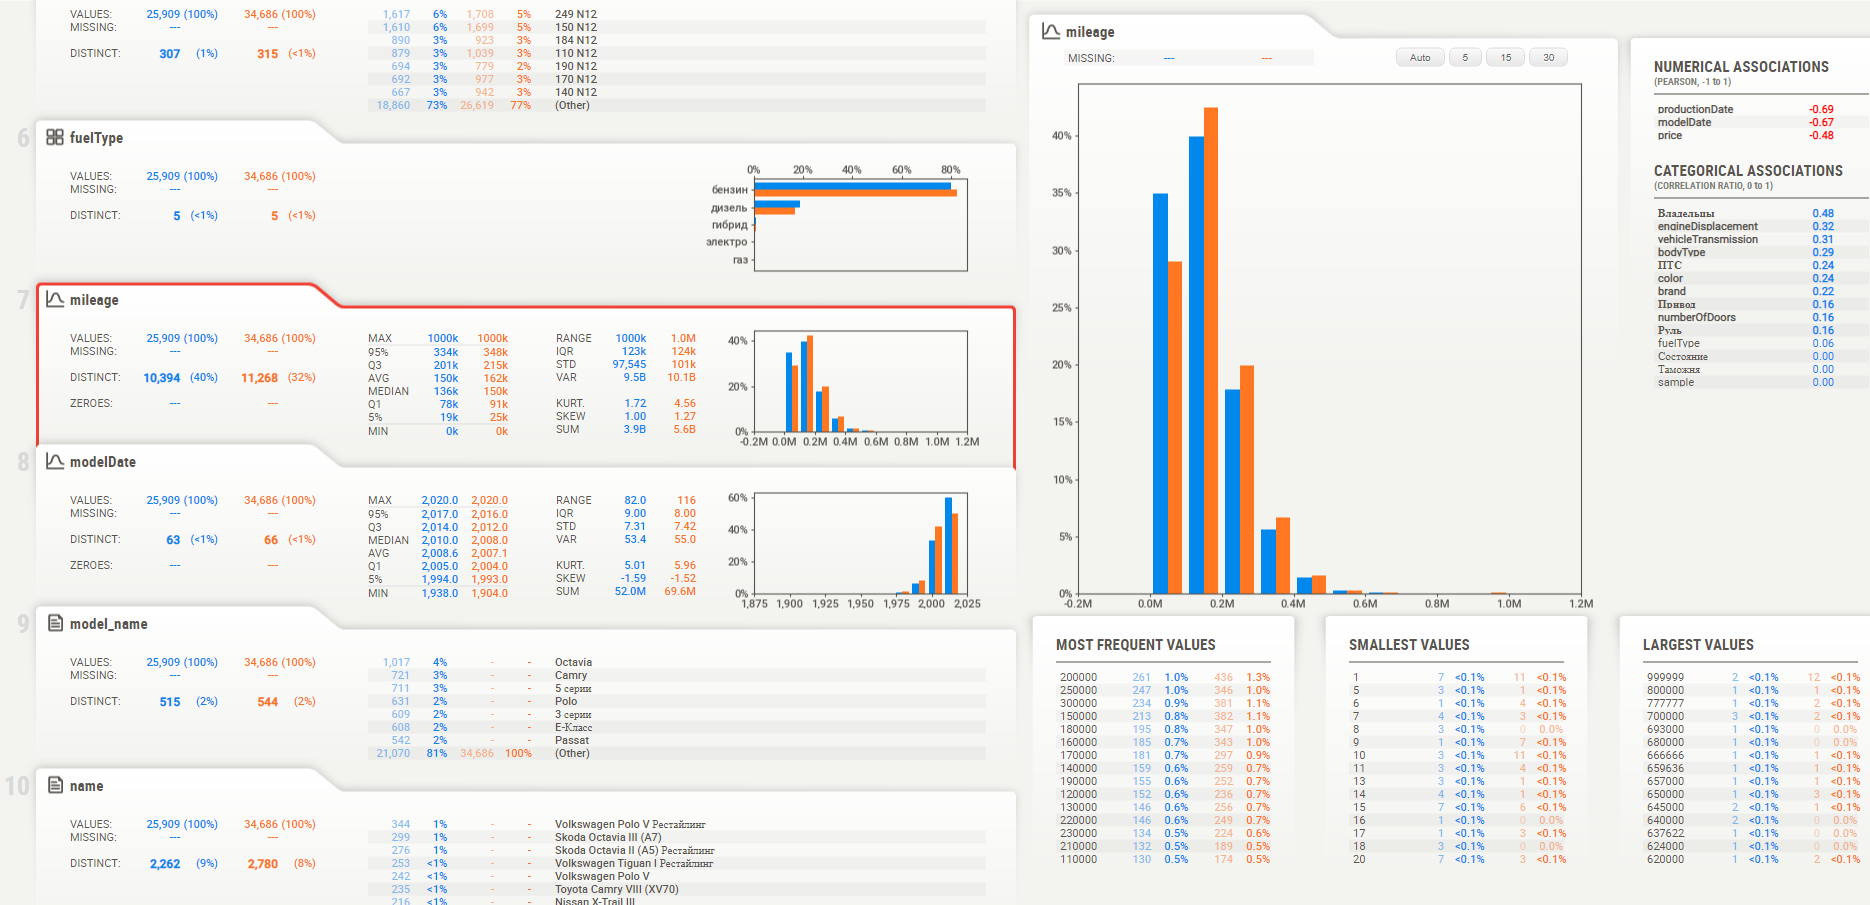

In [ ]:
# Приведем признаки к нижнему регистру
df['model_name'] = df['model_name'].str.lower()
df['brand'] = df['brand'].str.lower()
df['name'] = df['name'].str.lower()
df['model_name'] = df['model_name'].str.lower()
df['vehicleConfiguration'] = df['vehicleConfiguration'].str.lower()

In [ ]:
# Удалим информацию о количестве дверей из признака 'bodyType'
df['bodyType'] = df['bodyType'].str.replace('(.\d.\w+.)', '')

In [ ]:
# В тестовом датасете присутвует тип кузова фастбек, которого нет в трейне
df[df['bodyType'] == 'фастбек']

In [ ]:
# Заменим данное значение на хэтчбек
df['bodyType'] = df['bodyType'].apply(
    lambda x: 'хэтчбек' if x == 'фастбек' else x)

In [ ]:
df['engineDisplacement'].value_counts()

In [ ]:
# Имеются значения вида ' LTR', посмотрим на них
df[df['engineDisplacement'] == ' LTR']

In [ ]:
# Как видим, объем двигателя не указан для электромобилей

In [ ]:
# Заменим недостающие значения на моду
df['engineDisplacement'] = df['engineDisplacement'].apply(
    lambda x: '2.0 LTR' if x == ' LTR' else x)

In [ ]:
# Преобразим столбцы 'engineDisplacement' и 'enginePower' в числовой формат
df['engineDisplacement'] = df['engineDisplacement'].apply(
    lambda x: float(x.split()[0]))
df['enginePower'] = df['enginePower'].apply(
    lambda x: int(x.split()[0]))

In [ ]:
# Столбцы 'name' и 'vehicleConfiguration' не несут в себе полезных данных, удалим их
df.drop(['name', 'vehicleConfiguration'], axis=1, inplace=True)

In [ ]:
# В столбцах 'Состояние' и 'Таможня' находится по одному значению, удалим их
df.drop(['Состояние', 'Таможня'], axis=1, inplace=True)

In [ ]:
# В столбце 'Владение' слишком много пропусков,поэтому удалим его
df.drop(['Владение'], axis=1, inplace=True)

In [ ]:
# В столбце 'ПТС' в трейне и тесте есть по одному пропущенному значению. Заменим их на дубликат
df['ПТС'].fillna('Дубликат', inplace=True)

In [ ]:
# В столбце 'numberOfDoors' есть однин автомобиль со значением 0,посмотрим на него
df[df['numberOfDoors'] == 0]

In [ ]:
# Это раритетный автомобиль, заменим количество дверей на 2
df['numberOfDoors'] = df['numberOfDoors'].apply(lambda x: 2 if x == 0 else x)

# 3. Feature Engineering

In [ ]:
# Добавим несколько переменных в наш датасет
# Новизна модели
df['model_age'] = df['productionDate'] - df['modelDate']
# Возраст авто. 2021 год так же считаем за год
df['avto_age'] = (2021-df['productionDate'])+1

In [ ]:
# Появились несколько выбросов,у которых год производства меньше года модели
df[df['model_age'] < 0]

In [ ]:
# Заменим данные значения на 0
df['model_age'] = df['model_age'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
# Добавим признак 'km_per_year', показывающий пробег за год
df['km_per_year'] = df['mileage'] / df['avto_age']

In [ ]:
# Добавим бинарный признак, указывающий на премиальность бренда
df['luxury'] = df['brand'].apply(
    lambda x: 'Да' if x in ['bmw', 'mercedes', 'lexus', 'infiniti'] else 'нет')

In [ ]:
# Добавим новый признак, указывающий транспортный налог, в зависимости от мощности авто, по ставке за 2021 год
def car_tax(x):
    if x <= 100:
        return x*12
    elif x <= 125:
        return x*25
    elif x <= 150:
        return x*35
    elif x <= 175:
        return x*45
    elif x <= 200:
        return x*50
    elif x <= 225:
        return x*65
    elif x <= 250:
        return x*75
    else:
        return x*150


df['tax'] = df['enginePower'].apply(car_tax)

# 4. EDA

In [ ]:
# # Рассмотрим получившийся датасет подробнее
# df_sv_1 = sv.compare(df[df['sample']==1], df[df['sample']==0])
# df_sv_1.show_notebook()
# df_sv_1.show_html('Compare_1.html')

##### Как видим, соотношение всех значений в трейне и тесте примерно одинаково.
##### При увеличении engineDisplacement и enginePower растет и цена.Параметр пробега отрицательно коррелирует с параметрами productionDate, modelDate и price. Так же, с этими параметрами коррелирует количество владельцев, так как чем больше было владельцев у автомобиля, тем ,скорее всего, он старее.
##### Чем новее автомобиль, тем болше его цена. Но так  есть старые раритетные авто, у котрых цена очень высокая.
##### В признаке  mileage присутсвуют выбросы в большую сторону. Так же в признаках modelDate и productionDate существуют выбросы в меньшую сторону, скорее всего это раритетные автомобили.
##### Наблюдается корреляция между признаками modelDate, productionDate, model_age и avto_age. Все выбросы пока оставляем на месте.
##### Price хорошо коррелирует с числовыми признаками  enginePower, mileage, productionDate, avto_age, modelDate и engineDisplacement, а так же с признаками brand, Привод и luxury.
##### Признаки engineDisplacement, enginePower и tax так же имеют высокую корреляцию. 

In [ ]:
# Рассмотрим авто, произведенные до 1970 года.
df[df['productionDate'] < 1970]

##### Данные авто очень дорогие, поэтому выбросы по этому признаку оставим

In [ ]:
# Рассмотрим авто,с пробегом больше 600000
df[df['mileage'] > 600000]

##### На данном этапе оставим все выбросы на месте, обучим модель и проверим, улучшится ли метрика после удаления выбросов

In [ ]:
df.head(1)

In [ ]:
# Создадим списки с типами наших значений

# Категориальные признаки
cat_cols = ['bodyType', 'brand', 'color', 'fuelType',
            'numberOfDoors', 'model_name', 'vehicleTransmission', 'Привод']

# Числовые признаки
num_cols = ['engineDisplacement', 'enginePower', 'tax', 'mileage',
            'km_per_year', 'modelDate', 'productionDate', 'model_age', 'avto_age']

# Бинарные признаки
bin_cols = ['ПТС', 'Руль', 'luxury']

# Категориальные порядковые признаки
ordinal_cat_cols = ['Владельцы']

In [ ]:
# # Логарифмируем  числовые признаки
# df_num[['engineDisplacement','enginePower','tax','mileage','km_per_year','modelDate','productionDate','avto_age','price']] = np.log(df_num[['engineDisplacement','enginePower','tax','mileage','km_per_year','modelDate','productionDate','avto_age','price']])
# df_num['model_age'] = np.log(df_num['model_age']+1)

In [ ]:
# # Рассмотрим отдельно числовые признаки после взятия логарифма 
# df_num_log = sv.compare(df_num[df_num['sample']==1][num_cols+['price']], df_num[df_num['sample']==0][num_cols+['price']])
# df_num_log.show_notebook()
# df_num_log.show_html('Compare_num_log.html')

##### Логарифмирование числовых признаков улучшило их  распределение.Так же усилилась зависимость цены от возраста авто,его пробега и мощности. Признаки model_age и km_per_year  связаны с целевой переменной слабее всего. Не будем использовать их в дальнейшем. Так же, из за усиления связи price и avto_age, признак productionDate тоже не будет использоваться.
##### Так как признаки tax и enginePower очень сильно скоррелированы, а enginePower имеет большее значение для целевой переменной, признак tax не будет использоваться

In [ ]:
num_cols.remove('model_age')
num_cols.remove('km_per_year')
num_cols.remove('productionDate')
num_cols.remove('tax')

In [ ]:
# Логарифмируем числовые признаки
df[num_cols+['price']] = np.log(df[num_cols+['price']])

In [ ]:
plt.figure(figsize=(16, 10))
sns.heatmap(df[num_cols+['price']].corr().abs(), vmin=-1, vmax=1, annot=True)
plt.show()

In [ ]:
all_cols = cat_cols+num_cols+ordinal_cat_cols+bin_cols

# 5. Data Preprocessing

In [ ]:
# Создадим копию готового датасета
df_1 = df[all_cols+['price', 'sample']].copy()
df_1

In [ ]:
# Обработаем датасет для обучения

# Закодируем категориальные признаки
for col in cat_cols:
    df_1[col] = df_1[col].astype('category').cat.codes

# Стандартизируем числовые признаки
df_1[num_cols] = StandardScaler().fit_transform(df_1[num_cols])

# Закодируем бинарные признаки
for column in bin_cols:
    df_1[column] = LabelEncoder().fit_transform(df_1[column])

# Закодируем категориальный порядковый признак
df_1[ordinal_cat_cols] = OrdinalEncoder().fit_transform(df_1[ordinal_cat_cols])

In [ ]:
# Разделим датасет с используемыми признаками
X = df_1[df_1['sample'] == 1].drop(['sample', 'price'], axis=1)
y = df_1[df_1['sample'] == 1]['price']
test_df = df_1[df_1['sample'] == 0].drop(['sample', 'price'], axis=1)

In [ ]:
# Создадим еще один датасет,в котором не будем проводить обработку переменных
# Так же,все нечисловые  признаки объявим категориальными
df_2 = df[all_cols+['price', 'sample']].copy()
df_2[cat_cols+bin_cols+ordinal_cat_cols] = df_2[cat_cols +
                                                bin_cols+ordinal_cat_cols].astype('category')
X_2 = df_2[df_2['sample'] == 1].drop(['sample', 'price'], axis=1)
y_2 = df_2[df_2['sample'] == 1]['price']
test_df_2 = df_2[df_2['sample'] == 0].drop(['sample', 'price'], axis=1)

# 6. Machine Learning

In [ ]:
# Подготовим данные для обучения
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# Необработанный датасет
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_2, y_2, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

## 6.1 Базовая модель

In [ ]:
# В качестве базовой модели будем использовать RandomForestRegression, обученную без настройки параметров
base_model = RandomForestRegressor(random_state=RANDOM_SEED)
results = model_results('RandomForestRegressor со стандартными настройками',
                        base_model, X_train, X_test, y_train, y_test)
results

In [ ]:
# base_model.fit(X_train,y_train)
# y_pred =  base_model.predict(test_df)
# y_pred = np.exp(y_pred)

In [ ]:
# # mape на платформе= 18.219
# sample_submission['price'] = y_pred
# sample_submission.to_csv('base_sub.csv', index=False)
# sample_submission.head(3)

In [ ]:
# # Обучение на всем трейне mape = 17.91004
# base_model.fit(X,y)
# y_pred =  base_model.predict(test_df)
# y_pred = np.exp(y_pred)
# sample_submission['price'] = y_pred
# sample_submission.to_csv('base_sub.csv', index=False)
# sample_submission.head(3)

## 6.2 CatBoost

In [ ]:
# Обучим CatBoost на обработанном датасете
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True)
results = results.append(model_results('CatBoost со стандартными настройками на обработанном датасете',model,X_train,X_test,y_train,y_test))
results

In [ ]:
# Посмотрим на важность признаков
importance =  model.get_feature_importance()
names = X_train.columns

named_importance = [[importance[i],names[i]] for i in range(len(names))]
print(np.array(sorted(named_importance,reverse = True)))

In [ ]:
# Попробуем обучить CatBoost на необработанных данных

categorical_features_indices = np.where(X_2.dtypes == 'category')[0]
train_pool_2 = Pool(data=X_train_2, label=y_train_2,
                    cat_features=categorical_features_indices)
test_pool_2 = Pool(data=X_test_2, label=y_test_2,
                   cat_features=categorical_features_indices)

In [ ]:
# Обучаем
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          cat_features = categorical_features_indices,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True)
results = results.append(model_results('CatBoost со стандартными настройками на необработанных данных',model,X_train_2,X_test_2,y_train_2,y_test_2))
results

In [ ]:
# В результате поиска оптимальных параметров на локальной машине для необработаных данных,
# получилось подобрать следующие параметры. Результат MAPE =  11.539440142997334
model_cat = CatBoostRegressor(iterations=15000,
                              #learning_rate = 0.05,
                              random_seed=RANDOM_SEED,
                              cat_features=categorical_features_indices,
                              one_hot_max_size=5,
                              loss_function='MAPE',
                              eval_metric='MAPE',
                              custom_metric=['R2', 'MAE'],
                              use_best_model=True,
                              silent=True)
model_cat.fit(train_pool_2, eval_set=test_pool_2, plot=True)

y_pred = model_cat.predict(X_test_2)
print(mape(np.exp(y_test_2), np.exp(y_pred)))

In [ ]:
# sample_submission = pd.read_csv('sample_submission.csv')
# predict_submission = model_cat.predict(test_df_2)
# predict_submission = np.exp(predict_submission)
# sample_submission['price'] = predict_submission
# sample_submission.to_csv('cat_sub_test.csv', index=False)
# sample_submission.head(3)

In [ ]:
# на кагле MAPE = 17.92599


In [ ]:
# Обучим на всем датасете и отправим сабмишн
model_cat_full = CatBoostRegressor(iterations=15000,
                                   #learning_rate = 0.05,
                                   random_seed=RANDOM_SEED,
                                   cat_features=categorical_features_indices,
                                   one_hot_max_size=5,
                                   loss_function='MAPE',
                                   eval_metric='MAPE',
                                   custom_metric=['R2', 'MAE'],
                                   use_best_model=True,
                                   silent=True)
model_cat_full.fit(X_2, y_2,
                   cat_features=categorical_features_indices,
                   eval_set=(X_test_2, y_test_2),
                   verbose=False,
                   use_best_model=True,
                   plot=False)
predict_submission = model_cat_full.predict(test_df_2)
predict_submission = np.exp(predict_submission)
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(3)

In [ ]:
# На платформе MAPE= 17.85899

Кросс валидация не улучшила метрику

## 6.3 EvalML

Применим библиотеку EvalML для поиска оптимальной модели

In [ ]:
# from evalml import AutoMLSearch
# from evalml.problem_types import detect_problem_type
# from evalml.problem_types import ProblemTypes
# from evalml.objectives import get_core_objectives
# from evalml.objectives.regression_objective import RegressionObjective

In [ ]:
# # Зададим метрику MAPE
# class MAPE(RegressionObjective):
#     name = 'MAPE'
#     greater_is_better = False
#     score_needs_proba = False
#     perfect_score = 0.0
#     is_bounded_like_percentage = False  # Range [0, Inf)

#     def objective_function(self, y_true, y_predicted, X=None):
#         if isinstance(y_true, pd.Series):
#             y_true = np.exp(y_true.values)
#         if isinstance(y_predicted, pd.Series):
#             y_predicted = np.exp(y_predicted.values)
#         scaled_difference = (y_true - y_predicted) / y_true
#         return np.abs(scaled_difference).mean() * 100

# objective = MAPE()

In [ ]:
# X_train, X_holdout, y_train, y_holdout = evalml.preprocessing.split_data(X, y, problem_type='regression', test_size=0.2, random_seed=RANDOM_SEED)

# automl = AutoMLSearch(X_train=X_train,y_train=y_train,problem_type='regression', objective=MAPE())
# automl.search()

В результате выполнения,лучшей моделью оказался XGBoost

## 6.4 Hyperopt

Для поиска оптимальных параметров импользуем hyperopt.
В качестве моделей возьмем XGBoost, CatBoost и LightGBM

In [ ]:
# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.mean(np.abs((np.exp(pred)-np.exp(y))/np.exp(y)))*100


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
lgb_fit_params = {
    'eval_metric': 'mape',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y,pred: np.mean(np.abs((np.exp(pred)-np.exp(y))/np.exp(y)))*100


# CatBoost parameters
ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.05)),
    'max_depth':         hp.choice('max_depth',         np.arange(5, 16, 1, dtype=int)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
    'n_estimators':      100,
    'eval_metric':       'RMSE',
}
ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.mean(np.abs((np.exp(pred)-np.exp(y))/np.exp(y)))*100

In [ ]:
class HPOpt(object):

    def __init__(self, X_train, X_test, y_train, y_test):
        self.x_train = X_train
        self.x_test  = X_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [ ]:
obj = HPOpt(X_train, X_test, y_train, y_test)

In [ ]:
xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [ ]:
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [ ]:
ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

В ходе обучения, лучший результат показал XGBoost. Далее попробуем найти его лучшие параметры

In [ ]:
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     500,
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.mean(np.abs((np.exp(pred)-np.exp(y))/np.exp(y)))*100

In [ ]:
class HPOptXGB(object):

    def __init__(self, X_train, X_test, y_train, y_test):
        self.x_train = X_train
        self.x_test  = X_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials,print(space_eval(space,result))

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'],n_jobs=-1)
        return self.train_reg(reg, para)
    
    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [ ]:
obj_1 = HPOptXGB(X_train, X_test, y_train, y_test)

In [ ]:
xgb_opt = obj_1.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=500)

На платформе и на локальной машине получились разные результаты метрики
Лучший MAPE на локальной машине = 11.473352540638695
На платформе - 11.571896182775406
Далее использовались парамтеры, полученные на локальной машине

В результате получили следующие параметры для модели:


In [ ]:
xgb_reg_params = {'colsample_bytree': 0.5,
          'learning_rate': 0.05,
          'max_depth': 15,
          'min_child_weight': 1,
          'n_estimators': 1000,
          'subsample': 0.8597599739259828}

Обучим модель с этими параметрами

In [ ]:
xgb_reg_params = {'colsample_bytree': 0.5,
          'learning_rate': 0.05,
          'max_depth': 15,
          'min_child_weight': 1,
          'n_estimators': 1000,
          'subsample': 0.8597599739259828}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 150,
    'verbose': False
}

xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func'] = lambda y, pred: np.mean(
    np.abs((np.exp(pred)-np.exp(y))/np.exp(y)))*100

xgb_reg = xgb.XGBRegressor(**xgb_para['reg_params'],n_jobs=-1)

xgb_reg.fit(X_train,y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        **xgb_para['fit_params'])
        
y_pred = xgb_reg.predict(X_test)



print(mape(np.exp(y_test), np.exp(y_pred)))

Лучший результат на сабмишн показала модель, обученная на локальной машине  на X_train,y_train: MAPE = 17.06069
Обучение на всей тестовой выборке показало результат MAPE = 17.21461

# 7. Submission

In [ ]:
xgb_reg_params = {'colsample_bytree': 0.5,
          'learning_rate': 0.05,
          'max_depth': 15,
          'min_child_weight': 1,
          'n_estimators': 1000,
          'subsample': 0.8597599739259828}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 150,
    'verbose': True
}

xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func'] = lambda y, pred: np.mean(
    np.abs((np.exp(pred)-np.exp(y))/np.exp(y)))*100

xgb_reg = xgb.XGBRegressor(**xgb_para['reg_params'],n_jobs=-1)

xgb_reg.fit(X_train,y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        **xgb_para['fit_params'])
        
y_pred = xgb_reg.predict(test_df)
y_pred = np.exp(y_pred)
sample_submission['price'] = y_pred
sample_submission.to_csv('xgb_sub_test.csv', index=False)
sample_submission.head(3)

# 8. Выводы

##### В ходе работы: 
- был собран тренировочный датасет, включающий в себя 26242 записей с сайта авто.ру. 
- проведены анализ, очистка и обработка тестового и тренировочного датасета. 
- построены различные модели обучения.
- выполнен подбор оптимальных гиперпараметров моделей.

Получилось добиться метрики MAPE = 17.06069 на кагле и 11.473352540638695 на локальной машине. 
Для дальнейшего уменьшения метрики необходимо собрать больше данных в тренировочный датасет.